In [11]:
#Mount my drive- run the code, go to the link, accept.
from google.colab import drive
drive.mount('/content/gdrive')

#Change working directory to make it easier to access the files
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/dinn")
os.getcwd() 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/My Drive/Colab Notebooks/dinn'

In [12]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math

cholera_data = genfromtxt('cholera.csv', delimiter=',') #in the form of [t, S,I,B]

torch.manual_seed(1234)

In [13]:
%%time

PATH = 'cholera' 

class DINN(nn.Module):
    def __init__(self, t, S_data, I_data, B_data):
        super(DINN, self).__init__()
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.S = torch.tensor(S_data)
        self.I = torch.tensor(I_data)
        self.B = torch.tensor(B_data)
        self.H = torch.tensor(10000)

        self.losses = [] #keep the losses
        self.save = 3 #which file to save to

        #learnable parameters
        self.n_tilda = torch.tensor(0.0001)
        self.a_tilda = torch.tensor(1)
        self.K_tilda = torch.tensor(106)
        self.r_tilda = torch.tensor(0.2)
        self.e_tilda = torch.tensor(10)
        #self.lambdda_tilda = torch.tensor(self.B / (self.K_tilda + self.B))

        #matrices (x3 for S, B, I) for the gradients
        self.m1 = torch.zeros((len(self.t), 3)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 3)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 3)); self.m3[:, 2] = 1

        #values for norm
        self.S_max = max(self.S)
        self.B_max = max(self.B)
        self.I_max = max(self.I)
        self.S_min = min(self.S)
        self.B_min = min(self.B)
        self.I_min = min(self.I)

        #normalize 
        self.S_hat = (self.S - self.S_min)/(self.S_max - self.S_min)
        self.B_hat = (self.B - self.B_min)/(self.B_max - self.B_min)
        self.I_hat = (self.I - self.I_min)/(self.I_max - self.I_min)

        #NN
        self.net_cholera = self.Net_cholera()
        self.params = list(self.net_cholera.parameters())
        self.params.extend(list([self.n_tilda ,self.a_tilda ,self.K_tilda ,self.r_tilda ,self.e_tilda]))

        
    #force parameters to be in a range
    @property
    def n(self):
        return self.n_tilda
    @property
    def a(self):
        return self.a_tilda
    @property
    def K(self):
        return self.K_tilda
    @property
    def r(self):
        return self.r_tilda
    @property
    def e(self):
        return self.e_tilda
    # @property
    # def lambdda(self):
    #     return self.lambdda_tilda

    #nets
    class Net_cholera(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_cholera, self).__init__()
            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 3) #outputs S, B, I

        def forward(self, t):
            cholera=F.relu(self.fc1(t))
            cholera=F.relu(self.fc2(cholera))
            cholera=F.relu(self.fc3(cholera))
            cholera=F.relu(self.fc4(cholera))
            cholera=F.relu(self.fc5(cholera))
            cholera=F.relu(self.fc6(cholera))
            cholera=F.relu(self.fc7(cholera))
            cholera=F.relu(self.fc8(cholera))
            cholera=self.out(cholera)
            return cholera    

    def net_f(self, t_batch):       

        cholera_hat = self.net_cholera(t_batch)

        S_hat, B_hat, I_hat = cholera_hat[:,0], cholera_hat[:,1], cholera_hat[:,2]

        #S_hat
        cholera_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #B_hat
        cholera_hat.backward(self.m2, retain_graph=True)
        B_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_hat
        cholera_hat.backward(self.m3, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        B = self.B_min + (self.B_max - self.B_min) * B_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
     
        #equations
        lambdda = B / (self.K + B)

        f1_hat = S_hat_t - (self.n * (self.H - S) - self.a * lambdda * S) / (self.S_max - self.S_min) 
        f2_hat = B_hat_t - (B * (-0.33) + self.e * I) / (self.B_max - self.B_min) 
        f3_hat = I_hat_t - (self.a * lambdda * S - self.r * I) / (self.I_max - self.I_min) 

        return f1_hat, f2_hat, f3_hat, S_hat, B_hat, I_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        self.losses = checkpoint['losses']
        print('loaded previous loss: ', loss)
      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        S_pred_list = []
        B_pred_list = []
        I_pred_list = []

        f1_hat, f2_hat, f3_hat, S_hat_pred, B_hat_pred, I_hat_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_hat_pred)
        B_pred_list.append(self.B_min + (self.B_max - self.B_min) * B_hat_pred)
        I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_hat_pred)

        loss = (
              torch.mean(torch.square(self.S_hat - S_hat_pred)) + torch.mean(torch.square(self.B_hat - B_hat_pred)) + 
              torch.mean(torch.square(self.I_hat - I_hat_pred)) +
              torch.mean(torch.square(f1_hat)) + torch.mean(torch.square(f2_hat)) +
              torch.mean(torch.square(f3_hat))
               )

        loss.backward()

        self.optimizer.step()
        #self.scheduler.step() 
        self.scheduler.step(loss) 

        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 4000 == 0:
          #checkpoint save every 1000 epochs if the loss is lower
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

          print('epoch: ', epoch)
          # print('alpha1: (goal 1)', self.alpha1)
          # print('\nalpha2: (goal 0)', self.alpha2)
          # print('\nbeta: (goal 0.0075): ', self.beta)
          # print('\nmu (goal 5): ', self.mu)
          # print('\nu: (goal 0.515151515): ', self.u)
          # print('\ntao (goal 0.58): ', self.tao)
          print('#################################')
        
      #plot
      plt.plot(self.losses, color = 'teal')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      return S_pred_list, B_pred_list, I_pred_list

CPU times: user 50 µs, sys: 0 ns, total: 50 µs
Wall time: 59.8 µs



loading pre-trained model...
loaded previous loss:  tensor(0.0204, dtype=torch.float64, requires_grad=True)

starting training...


Epoch  0

Saving model... Loss is:  tensor(0.0204, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  0
#################################

Epoch  1000
Epoch 97927: reducing learning rate of group 0 to 2.2877e-05.

Epoch  2000

Epoch  3000

Epoch  4000

Saving model... Loss is:  tensor(0.0196, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  4000
#################################

Epoch  5000

Epoch  6000
Epoch 102928: reducing learning rate of group 0 to 2.0589e-05.

Epoch  7000

Epoch  8000

Saving model... Loss is:  tensor(0.0260, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  8000
#################################

Epoch  9000

Epoch  10000

Epoch  11000
Epoch 107929: reducing learning rate of group 0 to 1.8530e-05.

Epoch  12000

Saving model... Loss is:  tensor(0.0255, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  12000
###########

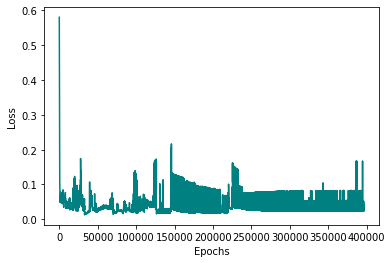

In [14]:
%%time

#this worked best
dinn = DINN(cholera_data[0], cholera_data[1], cholera_data[2], cholera_data[3])

learning_rate = 1e-4
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dinn.optimizer, factor=0.9, patience = 5000, verbose=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=100, mode="triangular2", cycle_momentum=False)

dinn.scheduler = scheduler

try: 
  S_pred_list, B_pred_list, I_pred_list = dinn.train(300000) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    S_pred_list, B_pred_list, I_pred_list = dinn.train(300000) #train
  elif dinn.save == 3:
    dinn.save = 2
    S_pred_list, B_pred_list, I_pred_list = dinn.train(300000) #train

Text(0, 0.5, 'Loss')

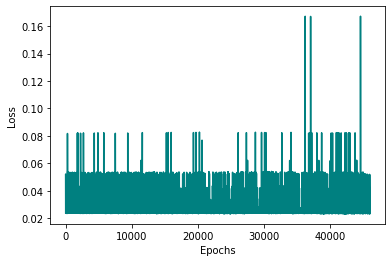

In [18]:
plt.plot(dinn.losses[350000:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')

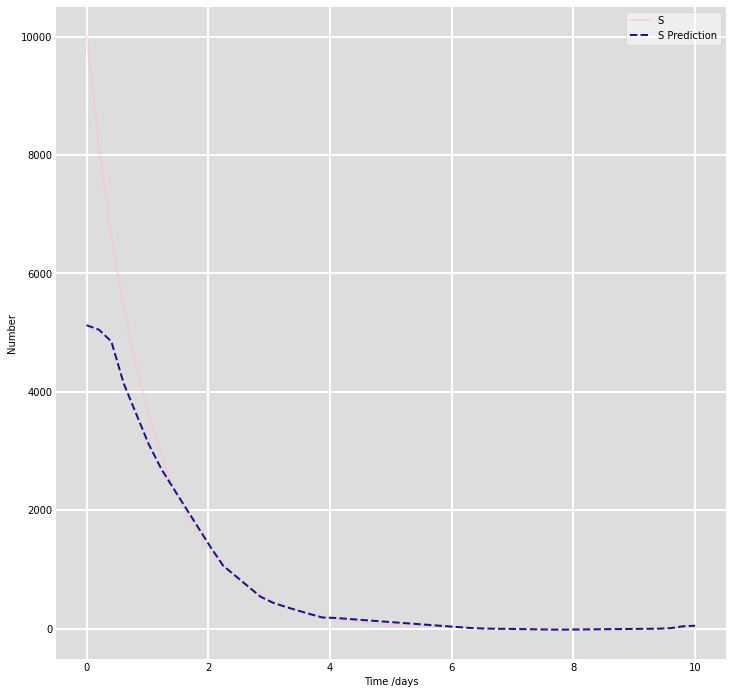

In [16]:
fig = plt.figure(facecolor='w', figsize=(12,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

ax.plot(cholera_data[0], cholera_data[1], 'pink', alpha=0.5, lw=2, label='S')
ax.plot(cholera_data[0], S_pred_list[0].detach().numpy(), 'navy', alpha=0.9, lw=2, label='S Prediction', linestyle='dashed')

# ax.plot(cholera_data[0], cholera_data[2], 'darkgreen', alpha=0.5, lw=2, label='I')
# ax.plot(cholera_data[0], I_pred_list[0].detach().numpy(), 'gold', alpha=0.9, lw=2, label='I Prediction', linestyle='dashed')

# ax.plot(cholera_data[0], cholera_data[3], 'violet', alpha=0.5, lw=2, label='B')
# ax.plot(cholera_data[0], B_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='B Prediction', linestyle='dashed')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [17]:
-print('alpha1: (goal 1)', round(dinn.alpha1.item(),2))
print('\nalpha2: (goal 0)', round(dinn.alpha2.item(),2))
print('\nbeta: (goal 0.0075): ', round(dinn.beta.item(),4))
print('\nmu (goal 5): ', round(dinn.mu.item(),2))
print('\nu: (goal 0.515151515): ', round(dinn.u.item(),2))
print('\ntao (goal 0.58): ', round(dinn.tao.item(),2))


print('\nerror:')
print('alpha1: ', round((1-round(dinn.alpha1.item(),2))/1,2)*100,'%')
print('alpha2: ', round((0-round(dinn.alpha2.item(),2))/1e-20,2)*100,'%')
print('beta: ', round((0.0075-round(dinn.beta.item(),4))/0.0075,2)*100,'%')
print('mu: ', round((5-round(dinn.mu.item(),2))/5,2)*100,'%')
print('u: ', round((0.515151515-round(dinn.u.item(),2))/0.515151515,2)*100,'%')
print('tao: ', round((0.58-round(dinn.tao.item(),2))/0.58,2)*100,'%')

AttributeError: ignored

In [ ]:
#vaccination! 

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial number of infected individuals, I0
I0 = 1
# Everyone else, S0, is susceptible to infection initially.
S0 = 2000
# Contact rate, beta, and mean recovery rate, mu.
beta, mu = dinn.beta, dinn.mu
# A grid of time points (in days)
t = np.linspace(0, 3, 100) 
#parameters
u = dinn.u
tao = dinn.tao
alpha1 = dinn.alpha1
alpha2 = dinn.alpha2

# The SIR model differential equations.
def deriv(y, t, beta, mu, u, tao, alpha1, alpha2):
    S, I = y
    dSdt = -beta * S * I + u * (t > tao) * alpha1 * (-S)
    dIdt = beta * S * I - mu * I + u * (t > tao) * alpha2 * (-I)
    return dSdt, dIdt

#add u = 0.5, get the corresponding tao, generate the SI data
# learn u (self.u), the corresponding tao (self.tao)

# Initial conditions vector
y0 = S0, I0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(beta, mu, u, tao, alpha1, alpha2))
S, I = ret.T

# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tSI_vaccination_data[0], tSI_vaccination_data[1], 'navy', alpha=0.9, lw=2, label='Actual Susceptible')
ax.plot(t, S, 'violet', alpha=0.5, lw=2, label='Learnable Param Susceptible', linestyle='dashed')
ax.plot(tSI_vaccination_data[0], tSI_vaccination_data[2], 'dodgerblue', alpha=0.9, lw=2, label='Actual Infected')
ax.plot(t, I, 'darkgreen', alpha=0.5, lw=2, label='Learnable Param Infected', linestyle='dashed')
ax.set_xlabel('Time /days')
#ax.set_ylabel('Number (1000s)')
#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [ ]:
#calculate relative MSE loss
import math

S_total_loss = 0
S_den = 0
I_total_loss = 0
I_den = 0
for timestep in range(len(t)):
  S_value = tSI_vaccination_data[1][timestep] - S[timestep]
  S_total_loss += S_value**2
  S_den += (tSI_vaccination_data[1][timestep])**2
  I_value = tSI_vaccination_data[2][timestep] - I[timestep]
  I_total_loss += I_value**2
  I_den += (tSI_vaccination_data[2][timestep])**2

S_total_loss = math.sqrt(S_total_loss/S_den)

I_total_loss = math.sqrt(I_total_loss/I_den)
print('S_total_loss: ', S_total_loss)
print('I_total_loss: ', I_total_loss)